In [4]:
import os
from rdkit import Chem
from rdkit import RDPaths
import numpy as np


from dgllife.model.model_zoo import gcn_predictor
from dgllife.utils import mol_to_graph
from dgllife.utils import mol_to_complete_graph
from dgllife.utils import CanonicalAtomFeaturizer
from dgllife.utils import CanonicalBondFeaturizer
from torch import nn

import torch
import dgl
if torch.cuda.is_available():
    print('use GPU')
    device='cuda'
else:
    print('use CPU')
    device='cpu'


import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss

use GPU


In [5]:
# Define paths to datasets
trainsdf = './RDKitBook/data/solubility.train.sdf'
testsdf =  './RDKitBook/data/solubility.test.sdf'

# Load molecules
trainmols = [m for m in Chem.SDMolSupplier(trainsdf)]
testmols = [m for m in Chem.SDMolSupplier(testsdf)]

# Define property dictionary
prop_dict = {
    "(A) low": 0,
    "(B) medium": 1,
    "(C) high": 2
}

# Featurizers and dataset preparation
atom_featurizer = CanonicalAtomFeaturizer()
n_feats = atom_featurizer.feat_size('h')

# Prepare training data
train_g = [mol_to_complete_graph(m, node_featurizer=atom_featurizer) for m in trainmols]
train_y = np.array([prop_dict[m.GetProp('SOL_classification')] for m in trainmols], dtype=np.int64)

# Prepare test data
test_g = [mol_to_complete_graph(m, node_featurizer=atom_featurizer) for m in testmols]
test_y = np.array([prop_dict[m.GetProp('SOL_classification')] for m in testmols], dtype=np.int64)

In [6]:
# Define the GCN model
gcn_net = gcn_predictor.GCNPredictor(
    in_feats=n_feats, 
    hidden_feats=[60, 20], 
    n_tasks=3, 
    classifier_hidden_feats=10, 
    predictor_dropout=0.5
)
gcn_net = gcn_net.to(device)

# Define data loader and optimizer
def collate(sample):
    graphs, labels = map(list, zip(*sample))
    batched_graph = dgl.batch(graphs)
    batched_graph.set_n_initializer(dgl.init.zero_initializer)
    batched_graph.set_e_initializer(dgl.init.zero_initializer)
    return batched_graph, torch.tensor(labels)

train_data = list(zip(train_g, train_y))
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate, drop_last=True)

classifier_hidden_feats is deprecated and will be removed in the future, use predictor_hidden_feats instead


In [7]:
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn_net.parameters(), lr=0.01)

# Training loop
for epoch in range(1, 501):
    epoch_loss = 0
    epoch_acc = 0
    for i, (bg, labels) in enumerate(train_loader):
        bg = bg.to(device)
        labels = labels.to(device)
        atom_feats = bg.ndata.pop('h').to(device)
        pred = gcn_net(bg, atom_feats)
        loss = loss_fn(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        pred_cls = pred.argmax(-1).detach().cpu().numpy()
        true_label = labels.cpu().numpy()
        epoch_acc += (true_label == pred_cls).sum() / true_label.shape[0]
    epoch_acc /= (i + 1)
    epoch_loss /= (i + 1)
    if epoch % 20 == 0:
        print(f"epoch: {epoch}, LOSS: {epoch_loss:.3f}, ACC: {epoch_acc:.3f}")

epoch: 20, LOSS: 0.402, ACC: 0.832
epoch: 40, LOSS: 0.321, ACC: 0.864
epoch: 60, LOSS: 0.297, ACC: 0.872
epoch: 80, LOSS: 0.240, ACC: 0.903
epoch: 100, LOSS: 0.224, ACC: 0.920
epoch: 120, LOSS: 0.209, ACC: 0.918
epoch: 140, LOSS: 0.189, ACC: 0.918
epoch: 160, LOSS: 0.156, ACC: 0.939
epoch: 180, LOSS: 0.196, ACC: 0.926
epoch: 200, LOSS: 0.163, ACC: 0.932
epoch: 220, LOSS: 0.208, ACC: 0.910
epoch: 240, LOSS: 0.128, ACC: 0.953
epoch: 260, LOSS: 0.162, ACC: 0.935
epoch: 280, LOSS: 0.141, ACC: 0.947
epoch: 300, LOSS: 0.127, ACC: 0.948
epoch: 320, LOSS: 0.157, ACC: 0.938
epoch: 340, LOSS: 0.113, ACC: 0.954
epoch: 360, LOSS: 0.128, ACC: 0.955
epoch: 380, LOSS: 0.185, ACC: 0.937
epoch: 400, LOSS: 0.124, ACC: 0.945
epoch: 420, LOSS: 0.114, ACC: 0.959
epoch: 440, LOSS: 0.103, ACC: 0.956
epoch: 460, LOSS: 0.107, ACC: 0.958
epoch: 480, LOSS: 0.102, ACC: 0.955
epoch: 500, LOSS: 0.107, ACC: 0.962


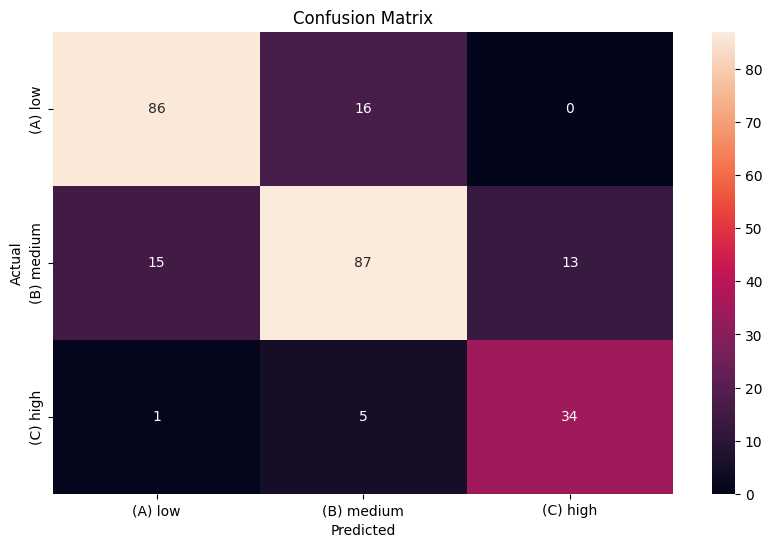

Precision: [0.84313725 0.80555556 0.72340426]
Recall: [0.84313725 0.75652174 0.85      ]
F1 Score: [0.84313725 0.78026906 0.7816092 ]


In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score  # Import confusion_matrix
# Evaluation on the test set
gcn_net.eval()
with torch.no_grad():
    test_data = list(zip(test_g, test_y))
    test_loader = DataLoader(test_data, batch_size=128, shuffle=False, collate_fn=collate, drop_last=False)
    
    all_preds = []
    all_labels = []
    
    for bg, labels in test_loader:
        bg = bg.to(device)
        labels = labels.to(device)
        atom_feats = bg.ndata.pop('h').to(device)
        pred = gcn_net(bg, atom_feats)
        pred_cls = pred.argmax(-1).cpu().numpy()
        true_label = labels.cpu().numpy()
        all_preds.extend(pred_cls)
        all_labels.extend(true_label)
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        confusion_matrix(all_labels, all_preds), 
        annot=True, fmt='d',
        xticklabels=list(prop_dict.keys()), yticklabels=list(prop_dict.keys())
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1 Score
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)

    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)